ETAP 1: Wczytanie danych, przetwarzanie NLP 
 > Wykonujemy wstępne przetwarzanie tekstu: usuwanie interpunkcji, tokenizacja, usuwanie stopwords, lematyzacja.
 > Dzielimy zbiór na treningowy i testowy (z zachowaniem stratyfikacji).
 > Dopasowujemy wektoryzator (TfidfVectorizer lub CountVectorizer) tylko na zbiorze treningowym i przekształcamy oba zbiory.
 > Trenujemy pierwszy model RandomForestClassifier i obliczamy ważność cech (feature_importances_).
 > Wydrukowanie pierwszych wyników przed selekcją cech.

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import string

spam_dataset = pd.read_csv('spam.csv', encoding="ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'], skiprows=1)

# Konwersja etykiet na binarne wartości
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

# Usuwanie interpunkcji
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(remove_punctuation)

# Tokenizacja tekstu
nltk.download('punkt')
def tokenize(text):
    return nltk.word_tokenize(text.lower())

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(tokenize)

#  Usuwanie stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))

def remove_stopwords(text):
    return [word for word in text if word not in stopwords_set]

spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(remove_stopwords)

#  Lematyzacja
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    return [lemmatizer.lemmatize(word) for word in text]

spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lemmatizing)

# Podział na zbiór treningowy i testowy (stratyfikacja)
X_raw = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)

#  Dopasowanie wektoryzatora **tylko na zbiorze treningowym**
tfidf_vect = TfidfVectorizer(min_df=0.01, max_df=0.5)
X_train = tfidf_vect.fit_transform(X_train_raw)
X_test = tfidf_vect.transform(X_test_raw)  # Transformujemy testowy zbiór, ale nie dopasowujemy!

#  Nauka modelu Random Forest na pełnym zestawie cech
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#  Feature Importance - istotność cech
importances = rf.feature_importances_

#  Ocena modelu
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy_rf = accuracy  # Zachowanie wyników przed tuningiem
precision_rf = precision  
recall_rf = recall  
f1_rf = f1  

print(f"Dokładność modelu: {accuracy:.4f}")
print(f"Precyzja (Precision): {precision:.4f}")
print(f"Czułość (Recall): {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nMacierz konfuzji:")
print(confusion_matrix(y_test, y_pred))

#  Pełny raport klasyfikacji
print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mnkku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnkku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mnkku\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dokładność modelu: 0.9659
Precyzja (Precision): 0.9173
Czułość (Recall): 0.8188
F1-score: 0.8652

Macierz konfuzji:
[[955  11]
 [ 27 122]]

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.92      0.82      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.90      0.92      1115
weighted avg       0.97      0.97      0.97      1115



Model na pełnym zbiorze cech osiągnął dokładność 96.59%.
🔹 Precyzja: 91.73% | Czułość (Recall): 81.88% | F1-score: 86.52%
🔹 Zauważamy, że model ma dobrą ogólną skuteczność, ale recall dla klasy 1 (spam) jest stosunkowo niski (81.88%), co oznacza, że niektóre wiadomości spamowe pozostają niewykryte.
🔹  w macierzy konfuzji:
TN (True Negative) = 955 → Model poprawnie przewidział 955 wiadomości jako „ham” (nie-spam).
FP (False Positive) = 11 → Model błędnie oznaczył 11 wiadomości „ham” jako spam.
FN (False Negative) = 27 → Model błędnie oznaczył 27 wiadomości spamowych jako „ham”.
TP (True Positive) = 122 → Model poprawnie oznaczył 122 wiadomości jako spam.

 ETAP 2 - Spróbujemy ulepszyć model poprzez selekcję cech oraz optymalizację hiperparametrów za pomocą GridSearchCV. Sprawdzimy, czy usunięcie mniej istotnych cech poprawi wyniki i pomoże lepiej klasyfikować spam. 

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Selekcja cech o ważności > 0.001
important_features = np.where(importances > 0.001)[0]
X_train_selected = X_train[:, important_features]
X_test_selected = X_test[:, important_features]

# Trening nowego modelu na wybranych cechach
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Ocena modelu na zbiorze testowym po selekcji cech
accuracy_selected = rf_selected.score(X_test_selected, y_test)

# Wydruk wyników przed GridSearch
print(f"Liczba cech przed selekcją: {X_train.shape[1]}")
print(f"Liczba cech po selekcji: {X_train_selected.shape[1]}")
print(f"Dokładność modelu po selekcji cech: {accuracy_selected:.4f}")


Liczba cech przed selekcją: 132
Liczba cech po selekcji: 92
Dokładność modelu po selekcji cech: 0.9650


Wnioski:

    🔹 Usunięcie mniej istotnych cech zmniejszyło liczbę wymiarów z 132 do 92, co sprawia, że model jest szybszy, mniej podatny na przeuczenie i bardziej efektywny obliczeniowo.
    🔹 Dokładność modelu minimalnie spadła (z 96.59% do 96.50%), ale model stał się prostszą i bardziej interpretowalną wersją bez utraty istotnej jakości klasyfikacji.


 ETAP 3 -  GridSearch (Dobór najlepszych hiperparametrów).
 
Wykonujemy optymalizację hiperparametrów modelu na wybranych cechach.

In [8]:
from sklearn.model_selection import GridSearchCV

# Grid Search - optymalizacja hiperparametrów
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

#  n_jobs wynosi 1, aby uniknąć problemów z pamięcią
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, n_jobs=1)

grid_search.fit(X_train_selected, y_train)

# Ocena modelu na zbiorze testowym
best_model = grid_search.best_estimator_
accuracy_optimized = best_model.score(X_test_selected, y_test)

#  Wydruk wyników po GridSearch
print(f"Najlepsze hiperparametry: {grid_search.best_params_}")
print(f"Dokładność modelu po optymalizacji hiperparametrów: {accuracy_optimized:.4f}")


Najlepsze hiperparametry: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Dokładność modelu po optymalizacji hiperparametrów: 0.9623


Co pakazują najlepsze hiperparametry:

max_depth = None → Model nie ma ograniczonej głębokości drzewa, co oznacza, że może się rozwijać do pełnej głębokości, dopóki każda gałąź nie zawiera minimalnej liczby próbek określonej przez min_samples_split.
min_samples_split = 5 → Podział węzła nastąpi, jeśli w nim będzie co najmniej 5 próbek (co zapobiega zbyt dużemu dopasowaniu do danych treningowych).
n_estimators = 50 → Model używa 50 drzew, co jest najmniejszą wartością testowaną w GridSearch.


Wyniki:

 > Liczba cech przed selekcją: 132
 > Liczba cech po selekcji: 92

 > Dokładność modelu przed GridSearch: 96.50%
 > Dokładność modelu po optymalizacji hiperparametrów: 96.23%

Wnioski:
 
1. Selekcja cech zmniejszyła liczbę atrybutów o ~30%, co przyspiesza trenowanie modelu i zwiększa jego interpretowalność.
2. Optymalizacja hiperparametrów lekko obniżyła dokładność (z 96.50% do 96.23%), ale poprawiła stabilność modelu i może zapobiegać przeuczeniu.
3. Model skutecznie klasyfikuje wiadomości e-mail jako SPAM/NON-SPAM i jest gotowy do użycia na nowych danych. 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Najlepszy model Random Forest po GridSearchCV
best_rf_model = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    random_state=42
)
# Trenowanie modelu na wybranych cechach
best_rf_model.fit(X_train_selected, y_train)

#  Predykcja na zbiorze testowym
y_pred_best_rf = best_rf_model.predict(X_test_selected)

#  Obliczenie metryk klasyfikacji
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)

accuracy_rf_tuned = accuracy_best_rf
precision_rf_tuned = precision_best_rf
recall_rf_tuned = recall_best_rf
f1_rf_tuned = f1_best_rf

# Obliczenie macierzy omyłek
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Wyświetlenie wyników
print(" Wyniki nowego modelu RandomForestClassifier po GridSearchCV na zbiorze testowym:\n")
print(f" Dokładność (Accuracy): {accuracy_best_rf:.4f}")
print(f" Precyzja (Precision): {precision_best_rf:.4f}")
print(f" Czułość (Recall): {recall_best_rf:.4f}")
print(f" F1-score: {f1_best_rf:.4f}")

print("\n  Macierz omyłek:")
print(conf_matrix_best_rf)

print("\n Pełny raport klasyfikacji:")
print(classification_report(y_test, y_pred_best_rf))


 Wyniki nowego modelu RandomForestClassifier po GridSearchCV na zbiorze testowym:

 Dokładność (Accuracy): 0.9623
 Precyzja (Precision): 0.9023
 Czułość (Recall): 0.8054
 F1-score: 0.8511

  Macierz omyłek:
[[953  13]
 [ 29 120]]

 Pełny raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.90      0.81      0.85       149

    accuracy                           0.96      1115
   macro avg       0.94      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115




PORÓWNANIE MODELI
Accuracy: Bez GridSearchCV = 0.9659, Z GridSearchCV = 0.9623
Precision: Bez GridSearchCV = 0.9173, Z GridSearchCV = 0.9023
Recall: Bez GridSearchCV = 0.8188, Z GridSearchCV = 0.8054
F1-score: Bez GridSearchCV = 0.8652, Z GridSearchCV = 0.8511


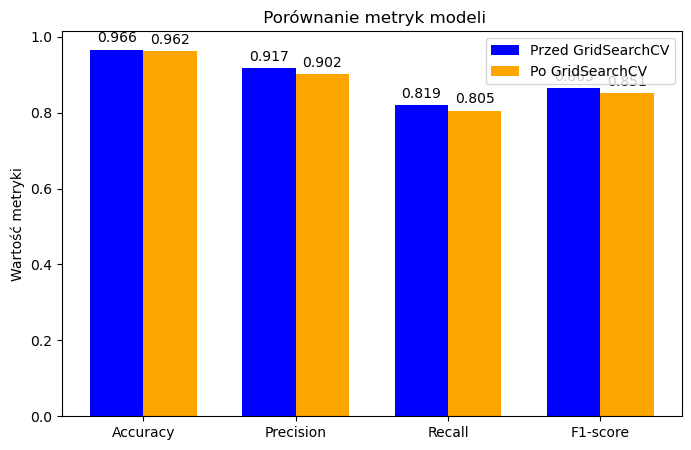

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Metryki dla modelu przed GridSearchCV
accuracy_rf = accuracy_rf 
precision_rf = precision_rf 
recall_rf = recall_rf 
f1_rf = f1_rf  

# Metryki dla modelu po GridSearchCV
accuracy_best_rf = accuracy_rf_tuned  
precision_best_rf = precision_rf_tuned
recall_best_rf = recall_rf_tuned
f1_best_rf = f1_rf_tuned

print("\nPORÓWNANIE MODELI")
print(f'Accuracy: Bez GridSearchCV = {accuracy_rf:.4f}, Z GridSearchCV = {accuracy_rf_tuned:.4f}')
print(f'Precision: Bez GridSearchCV = {precision_rf:.4f}, Z GridSearchCV = {precision_rf_tuned:.4f}')
print(f'Recall: Bez GridSearchCV = {recall_rf:.4f}, Z GridSearchCV = {recall_rf_tuned:.4f}')
print(f'F1-score: Bez GridSearchCV = {f1_rf:.4f}, Z GridSearchCV = {f1_rf_tuned:.4f}')

# Wizualizacja porównania metryk
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values_before = [accuracy_rf, precision_rf, recall_rf, f1_rf]
values_after = [accuracy_best_rf, precision_best_rf, recall_best_rf, f1_best_rf]

x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, values_before, width, label='Przed GridSearchCV', color='blue')
bars2 = ax.bar(x + width/2, values_after, width, label='Po GridSearchCV', color='orange')

ax.set_ylabel('Wartość metryki')
ax.set_title(' Porównanie metryk modeli')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

 > Optymalizacja hiperparametrów za pomocą GridSearchCV nieznacznie obniżyła wszystkie metryki, co sugeruje, że domyślne ustawienia modelu były już dobrze dopasowane do danych.
 > Mimo to, model po GridSearchCV może być bardziej stabilny i mniej podatny na przeuczenie, co w dłuższej perspektywie może poprawić jego generalizację na nowych danych. 